In [1]:
import os
import sys
import joblib
from tqdm import tqdm
import itertools
import numpy as np
import pandas as pd
from datetime import datetime

import warnings

# Silence that specific PyDataset warning
warnings.filterwarnings(
    "ignore",
    category=UserWarning
)

# Full suppression of GPU logs at OS level
sys.stderr = open(os.devnull, "w")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.hybrid_anomaly_util import *
from utils.utilities import load_model_outputs

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import Callback
from tqdm.notebook import tqdm

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc='Training Progress', unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
        loss = logs.get('loss')
        self.progress_bar.set_postfix({'loss': f'{loss:.4f}'})

    def on_train_end(self, logs=None):
        self.progress_bar.close()

ABS_PATH      = "/home/tristan/Desktop/SpringBoard/Projects/Martian-Weather-Analysis/"
DATA_PATH     = os.path.join(ABS_PATH, "data/processed/")
MODEL_PATH    = os.path.join(ABS_PATH, "models/")
LOG_PATH_ROOT = os.path.join(ABS_PATH, "logs/")
lstm_log_path = os.path.join(LOG_PATH_ROOT, "lstm_training.log")

E0000 00:00:1746708780.617527 3157111 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746708780.620155 3157111 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746708780.627881 3157111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746708780.627888 3157111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746708780.627889 3157111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746708780.627890 3157111 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Load in data
y_true_sarima, y_pred_sarima, residuals_sarima, metrics_sarima = load_model_outputs("SARIMA")
y_true_sarimax, y_pred_sarimax, residuals_sarimax, metrics_sarimax = load_model_outputs("SARIMAX")

Loaded outputs for SARIMA from model_outputs/
Loaded outputs for SARIMAX from model_outputs/


In [3]:
# Configure residuals for Hybrid
# --- SARIMA --- 
r1 = y_true_sarima - y_pred_sarima
r1 = r1.reshape(-1,1) # SARIMA

s1 = StandardScaler()
r1_scaled = s1.fit_transform(r1)

# --- SARIMAX ---
r2 = y_true_sarimax - y_pred_sarimax
r2 = r2.reshape(-1,1)

s2 = StandardScaler()
r2_scaled = s2.fit_transform(r2)

## SARIMA + LSTM

In [4]:
# Define sequence length
seq_len = 30
batch_size = 32

# --- SARIMA Based ---
r1_seq_gen = TimeseriesGenerator(
    r1_scaled, r1_scaled,
    length=seq_len,
    batch_size=batch_size
)
print("Number of training sequences")
print("___" * 10)
print(f"SARIMA Based: {len(r1_seq_gen)}")
print("---" * 10)

# --- SARIMAX Based ---
r2_seq_gen = TimeseriesGenerator(
    r2_scaled, r2_scaled,
    length=seq_len,
    batch_size=batch_size
)
print(f"SARIMAX Based: {len(r2_seq_gen)}")
print("___" * 10)


Number of training sequences
______________________________
SARIMA Based: 20
------------------------------
SARIMAX Based: 20
______________________________


## SARIMA + LSTM

In [5]:
# Define input dimensions
n_features = 1  # Residual is 1D
epochs = 20

# --- Build models ---
lstm_auto_sarima  = create_lstm_autoencoder(seq_len, n_features)
lstm_auto_sarimax = create_lstm_autoencoder(seq_len, n_features)

## SARIMAX + LSTM

In [6]:
# Instantiate the callback
tqdm_callback = TQDMProgressBar()

# --- Train SARIMA-based Autoencoder ---
print("Training SARIMA-based LSTM autoencoder...")
history_sarima = lstm_auto_sarima.fit(
    r1_seq_gen,
    epochs=epochs,
    verbose=0,
    callbacks=[tqdm_callback]
)

print("___" * 20)

# --- Train SARIMAX-based Autoencoder ---
print("\nTraining SARIMAX-based LSTM autoencoder...")
history_sarimax = lstm_auto_sarimax.fit(
    r2_seq_gen,
    epochs=epochs,
    verbose=0,
    callbacks=[tqdm_callback]
)


Training SARIMA-based LSTM autoencoder...


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

____________________________________________________________

Training SARIMAX-based LSTM autoencoder...


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

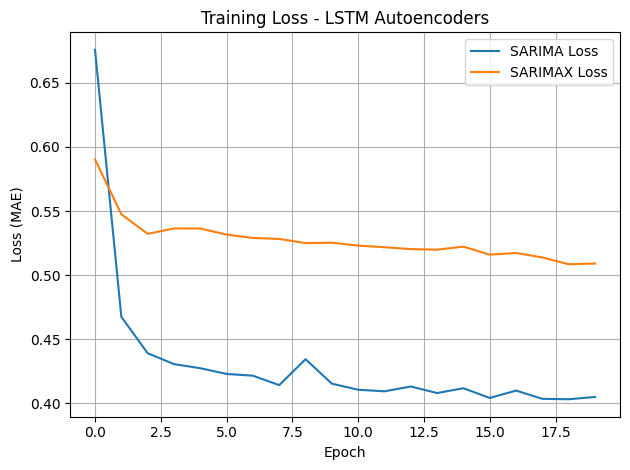

In [7]:
import matplotlib.pyplot as plt

plt.plot(history_sarima.history['loss'], label='SARIMA Loss')
plt.plot(history_sarimax.history['loss'], label='SARIMAX Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("Training Loss - LSTM Autoencoders")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# SARIMA-based
errors_sarima = compute_reconstruction_errors(lstm_auto_sarima, r1_seq_gen)
print("Complete")

In [ ]:
len(r2_seq_gen)

In [ ]:
# SARIMAX-based
errors_sarimax = compute_reconstruction_errors(lstm_auto_sarimax, r2_seq_gen)

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(errors_sarima, bins=50, alpha=0.6, label='SARIMA Errors')
plt.hist(errors_sarimax, bins=50, alpha=0.6, label='SARIMAX Errors')
plt.axvline(np.percentile(errors_sarima, 95), color='red', linestyle='--', label='SARIMA 95% Threshold')
plt.axvline(np.percentile(errors_sarimax, 95), color='blue', linestyle='--', label='SARIMAX 95% Threshold')
plt.title("Reconstruction Error Distributions")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()